<h2 align=left> Transfer Learning for NLP with TensorFlow Hub</h2>

---

### Overview

[TensorFlow Hub](https://tfhub.dev/) is a repository of pre-trained TensorFlow models.

In this project, you will use pre-trained models from TensorFlow Hub with [`tf.keras`](https://www.tensorflow.org/api_docs/python/tf/keras) for text classification. Transfer learning makes it possible to save training resources and to achieve good model generalization even when training on a small dataset. In this project, we will demonstrate this by training with several different TF-Hub modules.

### Learning Objectives

By the time you complete this project, you will be able to:

- Use various pre-trained NLP text embedding models from TensorFlow Hub
- Perform transfer learning to fine-tune models on your own text data
- Visualize model performance metrics with [TensorBoard](https://www.tensorflow.org/tensorboard)

### Contents

This project/notebook consists of several Tasks.

- **[Task 1]()**: Introduction to the Project.
- **[Task 2]()**: Setup your TensorFlow and Colab Runtime
- **[Task 3]()**: Download and Import the Quora Insincere Questions Dataset
- **[Task 4]()**: TensorFlow Hub for Natural Language Processing
- **[Task 5]()**: Define Function to Build and Compile Models
- **[Task 6]()**: Define Function to Build and Compile Models(Continued...)
- **[Task 7]()**: Train Various Text Classification Models
- **[Task 8]()**: Compare Accuracy and Loss Curves
- **[Task 9]()**: Fine-tuning Models from TF Hub
- **[Task 10]()**: Train Bigger Models and Visualize Metrics with TensorBoard

## Task 2: Setup your TensorFlow and Colab Runtime.

In [ ]:
!nvidia-smi

Fri Jun  9 11:57:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    33W /  70W |   9091MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)
from  IPython import display

import pathlib
import shutil
import tempfile

!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

print("Version: ", tf.__version__)
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

  Preparing metadata (setup.py) ... done
Version:  2.12.0
Hub version:  0.13.0
GPU is available


## Task 3: Download and Import the Quora Insincere Questions Dataset

A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [ ]:
df = pd.read_csv("https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip", compression="zip", low_memory=False)
df.shape

(1306122, 3)

<Axes: title={'center': 'Target Histogram Distribution'}, ylabel='Frequency'>

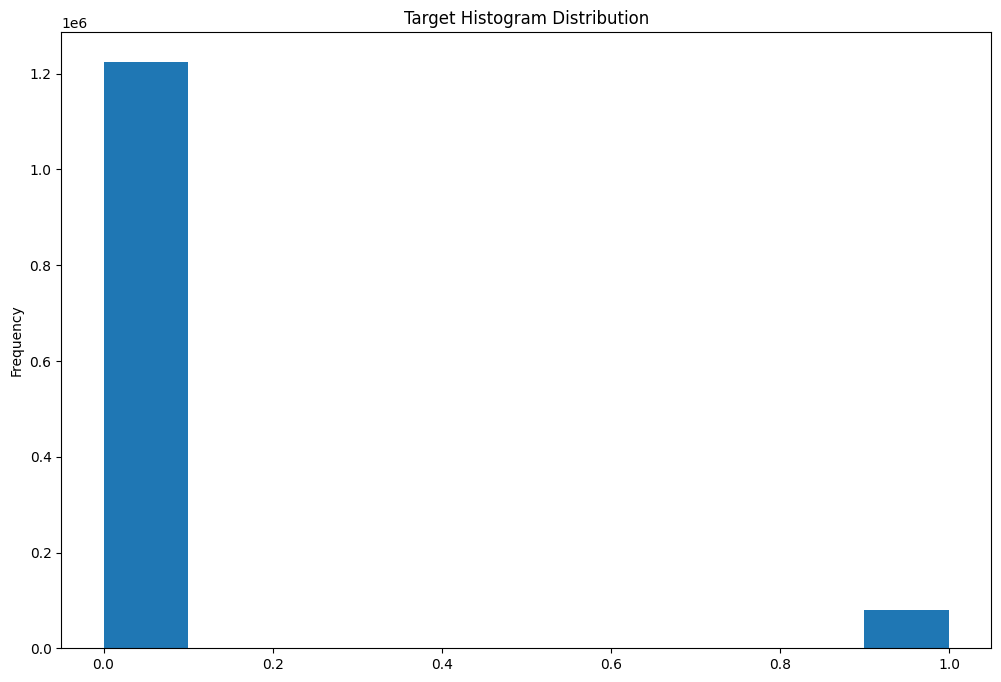

In [ ]:
# target corresponds to labels
df["target"].plot(kind="hist", title="Target Histogram Distribution")

In [ ]:
# split the data, and keep it the same
from sklearn.model_selection import train_test_split
train_df, rest_df = train_test_split(df, random_state = 10, train_size = 0.01, stratify = df.target.values)
valid_df, _ = train_test_split(rest_df, random_state = 10, train_size = 0.001, stratify = rest_df.target.values)

# check dimensions
train_df.shape, valid_df.shape

((13061, 3), (1293, 3))

In [ ]:
# check how many insincere comments are there in the first few samples
train_df.head(20).target.values

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# see what the comments are for the first few samples
train_df.head(20).question_text.values

array(['How do you become a decent fiction writer?',
       'Is it possible to get on the spot booking for stay in Jammu and Kashmir during August month or should I pre book hotels?',
       'My girlfriend of 7 years goes to club with 3 single friends who are looking to find partners, should I be concerned?',
       'Do the soldiers who play in the band have the same status as soldiers who fight in combat?',
       "When will you ever find an Indian that's more objective when viewing China?",
       'Why does love make you crazy?',
       'What is Steve Carrington’ from Dynasty MBTI?',
       'What are the causes of divorce in the US?',
       'What are the camcorders that record both on tapes and cards?',
       'Is it appropriate for a grandfather to walk around naked in front of his grand daughters aged 4 and 7. To invite them into the shower with him and ask them to help him choose what clothes to wear?',
       'Are there any stories that worked better in film than in print?',
   

## Task 4: TensorFlow Hub for Natural Language Processing

Our text data consits of questions and corresponding labels.

You can think of a question vector as a distributed representation of a question, and is computed for every question in the training set. The question vector along with the output label is then used to train the statistical classification model.

The intuition is that the question vector captures the semantics of the question and, as a result, can be effectively used for classification.

To obtain question vectors, we have two alternatives that have been used for several text classification problems in NLP:
* word-based representations and
* context-based representations

#### Word-based Representations

- A **word-based representation** of a question combines word embeddings of the content words in the question. We can use the average of the word embeddings of content words in the question. Average of word embeddings have been used for different NLP tasks.
- Examples of pre-trained embeddings include:
  - **Word2Vec**: These are pre-trained embeddings of words learned from a large text corpora. Word2Vec has been pre-trained on a corpus of news articles with  300 million tokens, resulting in 300-dimensional vectors.
  - **GloVe**: has been pre-trained on a corpus of tweets with 27 billion tokens, resulting in 200-dimensional vectors.


#### Context-based Representations

- **Context-based representations** may use language models to generate vectors of sentences. So, instead of learning vectors for individual words in the sentence, they compute a vector for sentences on the whole, by taking into account the order of words and the set of co-occurring words.
- Examples of deep contextualised vectors include:
  - **Embeddings from Language Models (ELMo)**: uses character-based word representations and bidirectional LSTMs. The pre-trained model computes a contextualised vector of 1024 dimensions. ELMo is available on Tensorflow Hub.
  - **Universal Sentence Encoder (USE)**: The encoder uses a Transformer  architecture that uses attention mechanism to incorporate information about the order and the collection of words. The pre-trained model of USE that returns a vector of 512 dimensions is also available on Tensorflow Hub.
  - **Neural-Net Language Model (NNLM)**: The model simultaneously learns representations of words and probability functions for word sequences, allowing it to capture semantics of a sentence. We will use a  pretrained  models available on Tensorflow Hub, that are trained on the English Google News 200B corpus, and computes a vector of 128 dimensions for the larger model and 50 dimensions for the smaller model.


Tensorflow Hub provides a number of [modules](https://tfhub.dev/s?module-type=text-embedding&tf-version=tf2&q=tf2) to convert sentences into embeddings such as Universal sentence ecoders, NNLM, BERT and Wikiwords.

Transfer learning makes it possible to save training resources and to achieve good model generalization even when training on a small dataset. In this project, we will demonstrate this by training with several different TF-Hub modules.

In [ ]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

## Tasks 5 & 6: Define Function to Build and Compile Models

In [ ]:
def train_and_evaluate_model(module_url, embed_size, model_name, trainable=False):
  # import model as keras layer, embed size is the dimensional vector, fixed embeddings when trainable is false
  hub_layer = hub.KerasLayer(module_url, input_shape=[], output_shape=[embed_size], dtype=tf.string, trainable=trainable)
  model = tf.keras.models.Sequential([hub_layer,
                                      tf.keras.layers.Dense(256, activation="relu"),
                                      tf.keras.layers.Dense(64, activation="relu"),
                                      tf.keras.layers.Dense(1, activation="sigmoid")
                                      ])
  # compile our model, callbacks for training multiple models, stops when val loss increases for 2 consecutive epochs
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss=tf.losses.BinaryCrossentropy(),
                metrics=[tf.metrics.BinaryAccuracy(name="accuracy")])
  fitted = model.fit(train_df["question_text"], train_df["target"], epochs=100, batch_size=32,
                      validation_data=(valid_df["question_text"], valid_df["target"]),
                      callbacks = [tfdocs.modeling.EpochDots(),
                                   tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience=2, mode="min"),
                                   tf.keras.callbacks.TensorBoard(logdir/model_name)],
                      verbose=0)
  model.summary()
  return fitted



## Task 7: Train Various Text Classification Models

In [ ]:
# to compare various models so save them all here
all_fitted = dict()

In [ ]:
module_url = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1" #@param ["https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1", "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", "https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"] {allow-input: true}

In [ ]:
# training the first model
all_fitted["gnews-swivel-20dim"] = train_and_evaluate_model(module_url, embed_size=20, model_name="gnews-swivel-20dim")


Epoch: 0, accuracy:0.9162,  loss:0.2877,  val_accuracy:0.9381,  val_loss:0.1985,  
......Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 20)                400020    
                                                                 
 dense_3 (Dense)             (None, 256)               5376      
                                                                 
 dense_4 (Dense)             (None, 64)                16448     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 421,909
Trainable params: 21,889
Non-trainable params: 400,020
_________________________________________________________________


In [ ]:
# train the second model
module_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1"
all_fitted["nnlm-en-dim50"] = train_and_evaluate_model(module_url, embed_size=50, model_name="nnlm-en-dim50")


Epoch: 0, accuracy:0.9349,  loss:0.3303,  val_accuracy:0.9381,  val_loss:0.2363,  
...........Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_6 (Dense)             (None, 256)               13056     
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 48,220,169
Trainable params: 29,569
Non-trainable params: 48,190,600
_________________________________________________________________


In [ ]:
# train the third model
module_url = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
all_fitted["nnlm-en-dim128"] = train_and_evaluate_model(module_url, embed_size=128, model_name="nnlm-en-dim128")


Epoch: 0, accuracy:0.9328,  loss:0.3099,  val_accuracy:0.9381,  val_loss:0.2142,  
...........Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 124,692,225
Trainable params: 49,537
Non-trainable params: 124,642,688
_________________________________________________________________


## Task 8: Compare Accuracy and Loss Curves

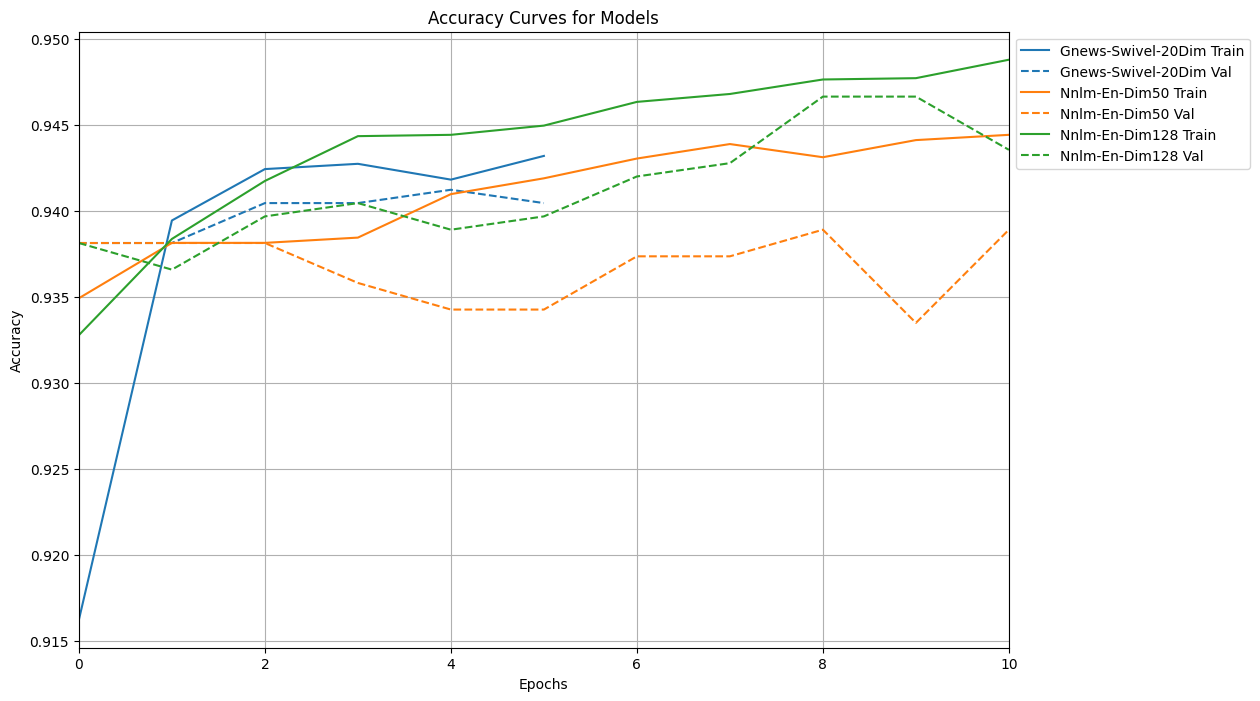

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(all_fitted)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

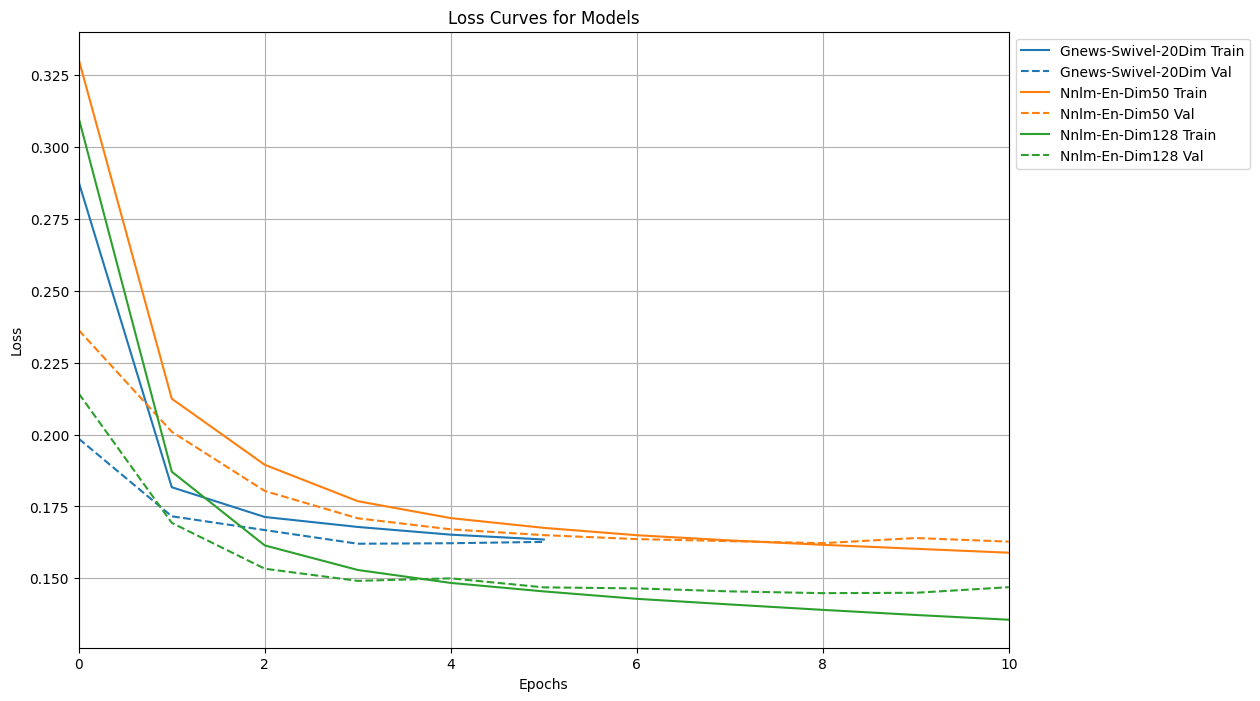

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss')
plotter.plot(all_fitted)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Loss Curves for Models")
plt.show()

## Task 9: Fine-tune Model from TF Hub

In [ ]:
# unfreeze hub layer
# finetune the first model
all_fitted["gnews-swivel-20dim-finetuned"] = train_and_evaluate_model(module_url,
                                                                      embed_size=20,
                                                                      model_name="gnews-swivel-20dim-finetuned",
                                                                      trainable=True)


Epoch: 0, accuracy:0.9255,  loss:0.3079,  val_accuracy:0.9381,  val_loss:0.1993,  
.....Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_5 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_15 (Dense)            (None, 256)               33024     
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 dense_17 (Dense)            (None, 1)                 65        
                                                                 
Total params: 124,692,225
Trainable params: 124,692,225
Non-trainable params: 0
_________________________________________________________________


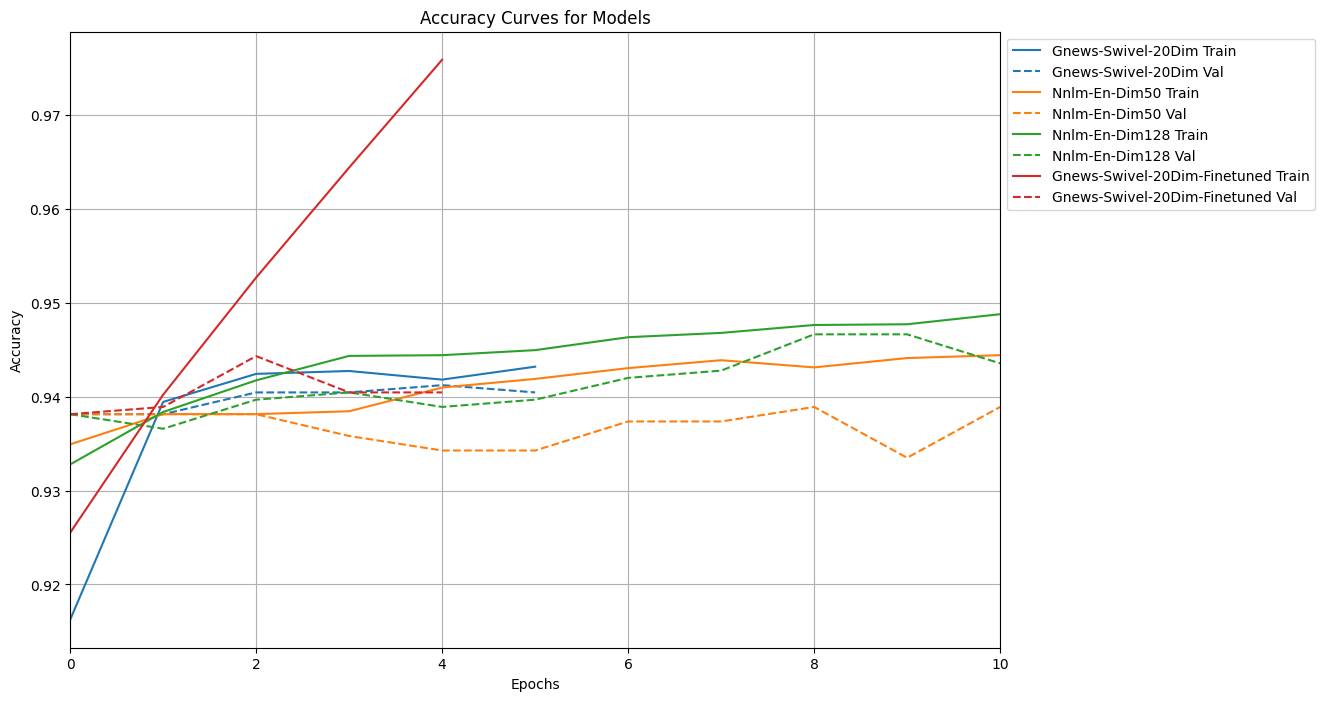

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(all_fitted)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()

## Task 10: Train Bigger Models and Visualize Metrics with TensorBoard

In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
all_fitted["universal-sentence-encoder"] = train_and_evaluate_model(module_url, embed_size=512, model_name="universal-sentence-encoder",
                                                        trainable=False)


Epoch: 0, accuracy:0.9222,  loss:0.3268,  val_accuracy:0.9381,  val_loss:0.1821,  
..............Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_6 (KerasLayer)  (None, 512)               256797824 
                                                                 
 dense_18 (Dense)            (None, 256)               131328    
                                                                 
 dense_19 (Dense)            (None, 64)                16448     
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,945,665
Trainable params: 147,841
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/5"
all_fitted["universal-sentence-encoder-large"] = train_and_evaluate_model(module_url, embed_size=512, model_name="universal-sentence-encoder-large",
                                                        trainable=False)


Epoch: 0, accuracy:0.9175,  loss:0.3188,  val_accuracy:0.9381,  val_loss:0.1705,  
.........Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_7 (KerasLayer)  (None, 512)               147354880 
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dense_22 (Dense)            (None, 64)                16448     
                                                                 
 dense_23 (Dense)            (None, 1)                 65        
                                                                 
Total params: 147,502,721
Trainable params: 147,841
Non-trainable params: 147,354,880
_________________________________________________________________


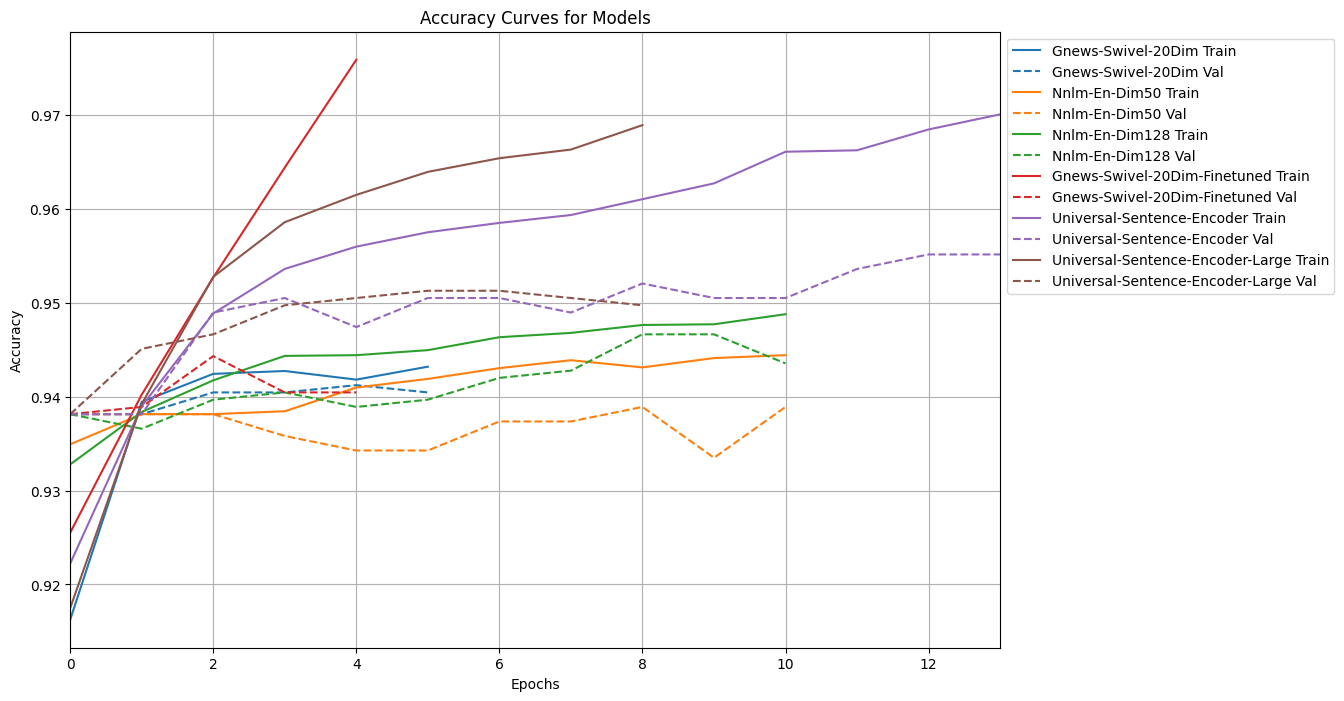

In [ ]:
plt.rcParams['figure.figsize'] = (12, 8)
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy')
plotter.plot(all_fitted)
plt.xlabel("Epochs")
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')
plt.title("Accuracy Curves for Models")
plt.show()